# NFT Price Prediction

In [1]:
# Install this package if not already installed in your system
!pip install explainerdashboard
!pip install xgboost catboost lightgbm
!pip install missingpy
!pip install sweetviz
!pip install ray 
!pip install ray[tune]
!pip install bayesian-optimization

  Using cached explainerdashboard-0.4.5-py3-none-any.whl.metadata (3.8 kB)
  Using cached dash_auth-2.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached dash_bootstrap_components-1.5.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached dash-2.15.0-py3-none-any.whl.metadata (11 kB)
  Using cached dtreeviz-2.2.2-py3-none-any.whl.metadata (2.4 kB)
  Using cached flask_simplelogin-0.1.2-py3-none-any.whl (7.2 kB)
  Using cached flask_wtf-1.2.1-py3-none-any.whl.metadata (3.4 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached jupyter_dash-0.4.2-py3-none-any.whl (23 kB)
  Using cached oyaml-1.0-py2.py3-none-any.whl (3.0 kB)
  Using cached shap-0.44.1-cp311-cp311-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached waitress-3.0.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached flask-3.0.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached plotly-5.18.0-py3-none-any.whl.metadata (7.0 kB)
  Using cache

In [5]:
## Importing necessary libraries
# Data Manipulation an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import plotly.express as px
# import sweetviz
# from pandas_profiling import ProfileReport
from tqdm import tqdm

# Python In-built
import re, os, string, json, csv, sys, random

# Scikit-Learn and other ML libraries
import xgboost, catboost, lightgbm
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# from missforest import MissForest

from bayes_opt import BayesianOptimization

# Interpretability Libraries
# import shap
# import explainerdashboard
# from explainerdashboard import ExplainerDashboard
# from explainerdashboard.explainers import RegressionExplainer

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

## DATA PREPARATION

In [7]:
## Reading datasets

# Reading collections file
'''
data about the collections (of NFTs) that are present in the training and prediction sets
'''
collections = pd.read_csv('./collections.csv')

# Reading collections twitter stats file
'''
Simple statistics about the Twitter accounts of the collections or the creators of the collections
'''
collections_twitter_stats = pd.read_csv('./collections_twitter_stats.csv')

# Reading nfts train file
'''
NFT data from all collections which can be, alongside the above info, used to train the price prediction model
'''
nfts_train = pd.read_csv('./nfts_train.csv')

# Reading nfts predict file
'''
NFT data from all collections whose price should be predicted using the trained model
'''
nfts_predict = pd.read_csv('./nfts_predict.csv')

#### Merging of all the dataframes to generate final train and test dataframes respectively. Here, collection_id is the unqiue column in each of the dataframe and is used as the key for merging operation.

In [8]:
# Merging collections and collections_twitter_stats dataframe and saving it to a dataframe -> collect_temp
collect_temp = collections.merge(collections_twitter_stats, how = 'outer', on ='collection_id')

In [9]:
# Merging the collect_temp (merged collections and collections_twitter_stats) dataframe with nfts_train to get the final train dataset
train = collect_temp.merge(nfts_train, how = 'outer', on = 'collection_id')

In [10]:
# Removing the unnamed columns from the train dataframe
def removeUnnamedCol(df):
    '''
    This function removes all the unnamed columns (unnecessary columns) from the dataframe and returns the cleaned dataframe
    Params:
        df -> dataframe
    '''
    for col in df.columns:
        if 'Unnamed' in col:
            del df[col]
    return df

In [11]:
# Removing the unnamed columns from the dataframe using the "removeUnnamedCol" function
train = removeUnnamedCol(train)
train.info()   # To check whether the Unnamed columns have been removed from the dataframe or not

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309924 entries, 0 to 309923
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   collection_id        309924 non-null  int64  
 1   total_supply         309924 non-null  int64  
 2   creation_date        309924 non-null  object 
 3   verification_status  309924 non-null  object 
 4   n_of_traits          309924 non-null  int64  
 5   contract_type        309924 non-null  object 
 6   seller_fees          277231 non-null  float64
 7   platform_fees        309924 non-null  int64  
 8   openrarity_enabled   309924 non-null  bool   
 9   has_website          309924 non-null  bool   
 10  has_own_twitter      309924 non-null  bool   
 11  has_discord          309924 non-null  bool   
 12  has_medium           309924 non-null  bool   
 13  n_tweets_in_range    309924 non-null  int64  
 14  avg_likes            309924 non-null  float64
 15  avg_replies      

In [12]:
# Merging collect_temp dataframe with nfts_predict to generate the final test dataset
test = collect_temp.merge(nfts_predict, how = 'outer', on = 'collection_id') 
test = removeUnnamedCol(test)  # To check whether the Unnamed columns have been removed from the dataframe or not
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181248 entries, 0 to 181247
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   collection_id        181248 non-null  int64  
 1   total_supply         181248 non-null  int64  
 2   creation_date        181248 non-null  object 
 3   verification_status  181248 non-null  object 
 4   n_of_traits          181248 non-null  int64  
 5   contract_type        181248 non-null  object 
 6   seller_fees          181246 non-null  float64
 7   platform_fees        181248 non-null  int64  
 8   openrarity_enabled   181248 non-null  bool   
 9   has_website          181248 non-null  bool   
 10  has_own_twitter      181248 non-null  bool   
 11  has_discord          181248 non-null  bool   
 12  has_medium           181248 non-null  bool   
 13  n_tweets_in_range    181248 non-null  int64  
 14  avg_likes            181248 non-null  float64
 15  avg_replies      

In [13]:
# Save Train and Test dataframes to csv files
train_init = train.copy(deep=True)
test_init  = test.copy(deep=True)
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [14]:
# Loading the train and test csv files from the disk generated from the earlier steps
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
# Summary of train set
train.describe()

,collection_id,total_supply,n_of_traits,seller_fees,platform_fees,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,...,max_likes,max_replies,max_retweets,global_index,nft_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_price
count,309924.000000,309924.000000,309924.000000,277231.000000,309924.0,309924.000000,309924.000000,309924.000000,309924.000000,309924.000000,...,309924.000000,309924.000000,309924.000000,309910.000000,309910.000000,309910.000000,80480.000000,80480.000000,80480.000000,3.099100e+05
mean,30.507018,13402.241946,10.558121,693.827710,250.0,17.170516,80.291093,20.314149,41.940449,12.595891,...,304.929986,107.701482,190.696535,317003.207947,6738.162024,1437.092531,1.000000,5630.164737,11255.829672,2.162269e+00
std,18.331593,7915.681978,4.879674,263.609478,0.0,27.078202,154.621154,62.246896,83.335729,33.552117,...,898.121337,445.343968,523.409254,173138.765569,5977.542096,4303.585892,0.152825,3812.126968,3452.713804,1.275132e+01
min,0.000000,1.000000,0.000000,200.000000,250.0,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,21928.000000,0.000000,1.000000,0.626738,1.000000,5555.000000,6.485360e-08
25%,13.000000,8888.000000,8.000000,500.000000,250.0,3.000000,2.000000,0.200000,1.153846,0.000000,...,5.000000,1.000000,5.000000,174892.250000,2453.000000,106.587184,0.906820,2515.750000,9928.000000,4.077085e-03
50%,34.000000,9999.000000,10.000000,750.000000,250.0,11.000000,8.153846,3.450000,8.166667,0.000000,...,30.000000,7.000000,34.000000,341467.500000,5138.000000,170.797030,0.978289,5030.000000,10000.000000,8.103344e-03
75%,46.000000,15000.000000,12.000000,1000.000000,250.0,19.000000,60.888889,8.500000,55.181818,2.000000,...,202.000000,47.000000,131.000000,493626.750000,8720.750000,289.614129,1.059866,8207.250000,15000.000000,3.252062e-01
max,60.000000,58351.000000,80.000000,1000.000000,250.0,668.000000,707.875000,353.400000,442.000000,236.000000,...,5079.000000,2601.000000,2990.000000,590227.000000,29898.000000,90354.072248,3.663833,15555.000000,15555.000000,1.024002e+03


In [16]:
# Correlation values of the train set
train.corr()

ValueError: could not convert string to float: '2021-04'

In [17]:
# Summary of test set
test.describe()

,collection_id,total_supply,n_of_traits,seller_fees,platform_fees,n_tweets_in_range,avg_likes,avg_replies,avg_retweets,min_likes,...,min_retweets,max_likes,max_replies,max_retweets,global_index,nft_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank
count,181248.000000,181248.000000,181248.000000,181246.000000,181248.0,181248.000000,181248.000000,181248.000000,181248.000000,181248.000000,...,181248.000000,181248.000000,181248.000000,181248.000000,181214.000000,181214.000000,181214.000000,38626.000000,38626.000000,38626.000000
mean,28.763390,26212.797212,12.636338,628.648632,250.0,61.351634,70.869551,14.532511,27.135821,19.381913,...,4.006555,161.286811,43.110523,80.898509,309791.155888,11445.662471,232.415184,1.000000,4372.867628,8741.760731
std,15.322493,20322.852507,14.518413,270.432416,0.0,167.590227,171.372887,26.073091,73.560090,52.653459,...,10.459517,336.054885,68.935597,200.544100,167228.382814,11585.749965,1392.046522,0.159457,2857.568048,2300.558399
min,0.000000,1.000000,0.000000,200.000000,250.0,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.601661,1.000000,3332.000000
25%,22.000000,9999.000000,8.000000,500.000000,250.0,1.000000,10.000000,5.333333,0.333333,0.000000,...,0.000000,15.000000,9.000000,1.000000,231959.250000,3235.250000,129.334538,0.880993,1925.000000,9854.000000
50%,35.000000,20279.000000,8.000000,500.000000,250.0,3.000000,11.333333,6.243902,3.000000,9.000000,...,1.000000,15.000000,9.000000,3.000000,287356.500000,7108.500000,178.813158,0.982769,3989.000000,9999.000000
75%,39.000000,58351.000000,10.000000,900.000000,250.0,8.000000,15.000000,9.000000,10.876316,10.000000,...,3.000000,81.000000,24.000000,46.000000,459554.750000,16220.000000,263.697190,1.086070,6767.000000,10000.000000
max,60.000000,58351.000000,80.000000,1000.000000,250.0,668.000000,707.875000,353.400000,442.000000,236.000000,...,46.000000,5079.000000,2601.000000,2990.000000,618141.000000,48256.000000,152922.000000,2.561688,10000.000000,10000.000000


## DATA PRE-PROCESSING

In [18]:
# Checking the number of missing values in the train dataframe
train_missing = train.isnull().sum().to_dict()  # contains sum of missing values for all columns in train
train_missing_dict = dict()  # empty dictionary to store keys/columns with missing values only (removing columns/keys from the previous step where sum is 0) for train
for key, val in train_missing.items():
    if val != 0:
        train_missing_dict[key] = val

train_missing_dict

{'seller_fees': 32693,
 'global_index': 14,
 'nft_id': 14,
 'rarity_score': 14,
 'openrarity_score': 229444,
 'openrarity_rank': 229444,
 'openrarity_max_rank': 229444,
 'last_sale_date': 14,
 'last_sale_price': 14}

In [19]:
# Checking the number of missing values in the test dataframe
test_missing = test.isnull().sum().to_dict() # contains sum of missing values for all columns in test
test_missing_dict = dict()  # empty dictionary to store keys/columns with missing values only (removing columns/keys from the previous step where sum is 0) for test
for key, val in test_missing.items():
    if val != 0:
        test_missing_dict[key] = val

test_missing_dict

{'seller_fees': 2,
 'global_index': 34,
 'nft_id': 34,
 'rarity_score': 34,
 'openrarity_score': 142622,
 'openrarity_rank': 142622,
 'openrarity_max_rank': 142622,
 'last_sale_date': 34}

In [20]:
# Displaying the rows in which the "last_sale_price" column has null values
train[train['last_sale_price'].isnull()]

,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,...,max_replies,max_retweets,global_index,nft_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
19888,53,9999,2022-07,verified,9,own,900.0,250,False,False,...,242,873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49418,29,9999,2022-05,verified,10,own,750.0,250,False,False,...,137,207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130261,39,58351,2021-10,approved,8,own,500.0,250,False,False,...,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130262,3,9124,2021-01,approved,26,default,1000.0,250,False,False,...,8,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153260,2,20279,2021-07,approved,7,default,200.0,250,False,False,...,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163261,10,3331,2022-02,approved,12,own,500.0,250,True,False,...,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171164,41,4961,2021-10,approved,15,default,1000.0,250,False,False,...,4,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171165,5,8881,2021-03,approved,8,default,900.0,250,False,False,...,75,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171166,42,22134,2021-01,approved,80,default,700.0,250,False,False,...,6,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238667,28,9996,2022-06,verified,14,own,250.0,250,True,False,...,4,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Checking which columns are of boolean data type
train.select_dtypes(include=bool)

,openrarity_enabled,has_website,has_own_twitter,has_discord,has_medium
0,False,False,True,True,True
1,False,False,True,True,True
2,False,False,True,True,True
3,False,False,True,True,True
4,False,False,True,True,True
...,...,...,...,...,...
309919,False,False,True,True,True
309920,False,False,True,True,True
309921,False,False,True,True,True
309922,False,False,True,True,True


In [22]:
# Displaying the string type columns 
train.select_dtypes(include = 'object')

,creation_date,verification_status,contract_type,last_sale_date
0,2021-04,verified,own,2022-11
1,2021-04,verified,own,2022-11
2,2021-04,verified,own,2022-11
3,2021-04,verified,own,2021-11
4,2021-04,verified,own,2021-11
...,...,...,...,...
309919,2022-04,verified,own,2022-08
309920,2022-04,verified,own,2022-08
309921,2022-04,verified,own,2022-08
309922,2022-04,verified,own,2022-08


In [23]:
# Value Counts of verification_status column
train.verification_status.value_counts()

verification_status
verified    179375
approved    130549
Name: count, dtype: int64

In [24]:
# Value Counts of contract_type column
train.contract_type.value_counts()

contract_type
own        169710
default    140214
Name: count, dtype: int64

In [25]:
# Checking the number of remaining rows after dropping null valued rows from " 'openrarity_enabled', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank' " columns
train[['openrarity_enabled', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank']].dropna()

,openrarity_enabled,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank
9888,True,95.156519,1.030583,3213.0,10000.0
9889,True,33.357764,0.814998,8878.0,10000.0
9890,True,35.812541,0.833099,8357.0,10000.0
9891,True,82.490056,0.859126,7514.0,10000.0
9892,True,123.194870,1.033852,3178.0,10000.0
...,...,...,...,...,...
296447,True,409.767485,1.287648,290.0,9999.0
296448,True,326.138664,0.994475,5090.0,9999.0
296449,True,354.386951,1.031258,3826.0,9999.0
296450,True,351.615855,1.033021,3632.0,9999.0


In [26]:
# Number of missing values in " 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank' " columns where openrarity is not enabled
train[train['openrarity_enabled'] == False][['openrarity_score', 'openrarity_rank', 'openrarity_max_rank']].isnull().sum()

openrarity_score       229439
openrarity_rank        229439
openrarity_max_rank    229439
dtype: int64

In [27]:
# Number of missing values in " 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank' " columns where openrarity is enabled
train[train['openrarity_enabled'] == True][['openrarity_score', 'openrarity_rank', 'openrarity_max_rank']].isnull().sum()

openrarity_score       5
openrarity_rank        5
openrarity_max_rank    5
dtype: int64

In [28]:
# Displaying the 5 rows {missing values in " 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank' " columns; where openrarity is enabled}
train[train[['openrarity_score', 'openrarity_rank', 'openrarity_max_rank']].isna().any(axis=1)][train['openrarity_enabled'] == True]

,collection_id,total_supply,creation_date,verification_status,n_of_traits,contract_type,seller_fees,platform_fees,openrarity_enabled,has_website,...,max_replies,max_retweets,global_index,nft_id,rarity_score,openrarity_score,openrarity_rank,openrarity_max_rank,last_sale_date,last_sale_price
163261,10,3331,2022-02,approved,12,own,500.0,250,True,False,...,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238667,28,9996,2022-06,verified,14,own,250.0,250,True,False,...,4,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268701,47,5267,2022-06,verified,0,own,750.0,250,True,False,...,49,143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296452,27,10000,2022-02,verified,18,own,500.0,250,True,False,...,185,159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309923,22,10000,2022-01,approved,5,own,500.0,250,True,False,...,24,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Encoding The Categorical Variables

In [29]:
# Using label encoding to encode the categorical variables
le1 = LabelEncoder() # Initializing Label Encoder for train set
le2 = LabelEncoder() # Initializing Label Encoder for test set

le_verification_tr = le1.fit_transform(train['verification_status'])   # verified assigned as 1 and approved assigned as 0 using label encoding on verification_status column
le_contract_tr     = le2.fit_transform(train['contract_type'])         # own -> 1 and default -> 0 for contract_type column

# Encoding "verification status and contract type" in train set
train['verification_status_encoded'] = le_verification_tr
train['contract_type_encoded']       = le_contract_tr

In [30]:
le_verification_te = le1.transform(test['verification_status'])
le_contract_te     = le2.transform(test['contract_type'])

# Encoding "verification status and contract type" in test set
test['verification_status_encoded'] = le_verification_te
test['contract_type_encoded']       = le_contract_te

### Converting creation_date column to datetime column dtype

In [31]:
train['creation_date'] = pd.to_datetime(train.creation_date)
test['creation_date']  = pd.to_datetime(test.creation_date)

### Encoding the Boolean type columns

In [32]:
train['openrarity_enabled'] = train['openrarity_enabled'].astype(int)
train['has_website']        = train['has_website'].astype(int)
train['has_own_twitter']    = train['has_own_twitter'].astype(int)
train['has_discord']        = train['has_discord'].astype(int)
train['has_medium']         = train['has_medium'].astype(int)

## Performing Train-Validation Split before EDA

In [33]:
# Creating X (input) and y (target) variables
X = train.drop(['last_sale_price'], axis=1)
y = train['last_sale_price']

In [34]:
# Splitting complete train set into train and validation; (validation set would be used for evaluating the model and performing hyperparameter tuning, cross-validation; test set to test on the final model trained)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
print(f'Shape of -> Full train set: {train.shape}; X train set: {X_train.shape}, y train set: {y_train.shape}, X validation set: {X_val.shape}, y validation set: {y_val.shape}; Full test set: {test.shape}')

Shape of -> Full train set: (309924, 33); X train set: (247939, 32), y train set: (247939,), X validation set: (61985, 32), y validation set: (61985,); Full test set: (181248, 32)


## EDA

### Total Supply

In [36]:
X_train['total_supply'].describe()

count    247939.000000
mean      13403.061862
std        7915.341055
min           1.000000
25%        8888.000000
50%        9999.000000
75%       15000.000000
max       58351.000000
Name: total_supply, dtype: float64

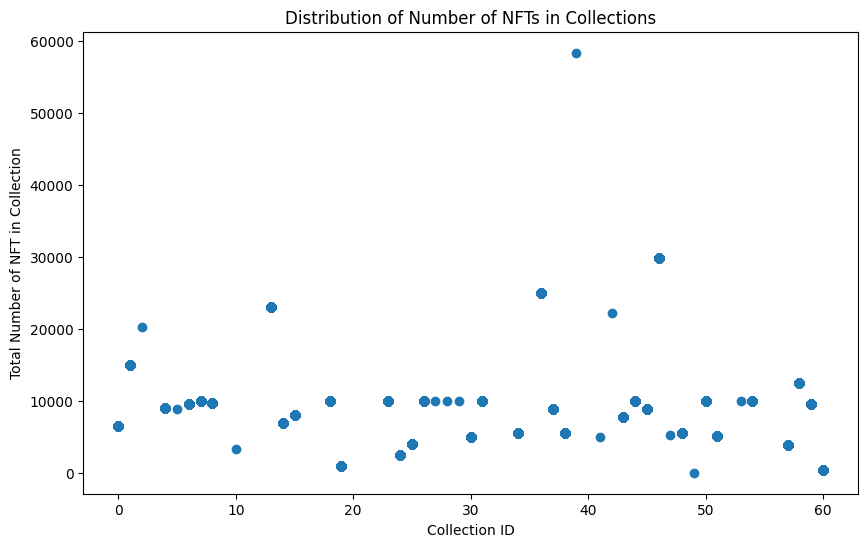

In [37]:
# Scatter PLot of total_supply with collection_id
plt.figure(figsize=(10,6))
plt.scatter(X_train.collection_id, X_train['total_supply'])
plt.xlabel('Collection ID')
plt.ylabel('Total Number of NFT in Collection')
plt.title('Distribution of Number of NFTs in Collections')
plt.show()

### Number of Traits

In [38]:
X_train['n_of_traits'].describe()

count    247939.000000
mean         10.558621
std           4.881739
min           0.000000
25%           8.000000
50%          10.000000
75%          12.000000
max          80.000000
Name: n_of_traits, dtype: float64

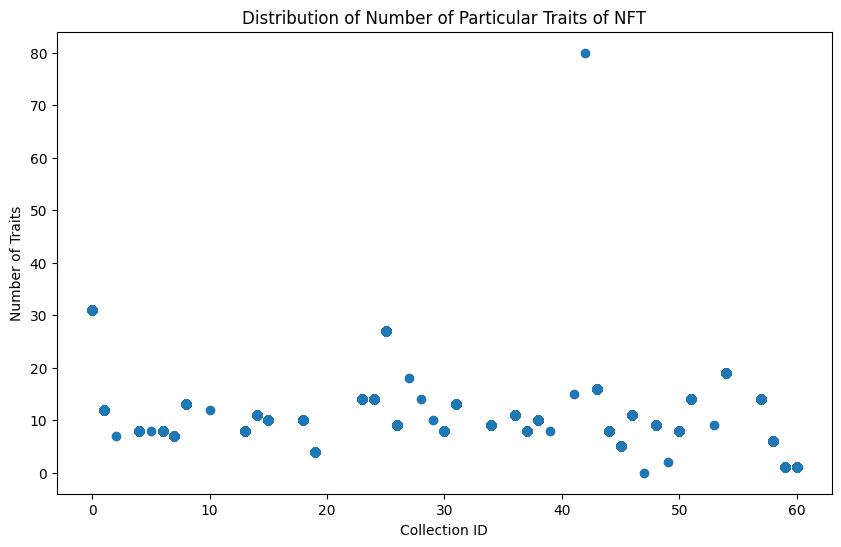

In [39]:
# Scatter Plot of number of traits with collection id
plt.figure(figsize=(10,6))
plt.scatter(X_train.collection_id, X_train['n_of_traits'])
plt.xlabel('Collection ID')
plt.ylabel('Number of Traits')
plt.title('Distribution of Number of Particular Traits of NFT')
plt.show()

### Last Sale Price (Target)

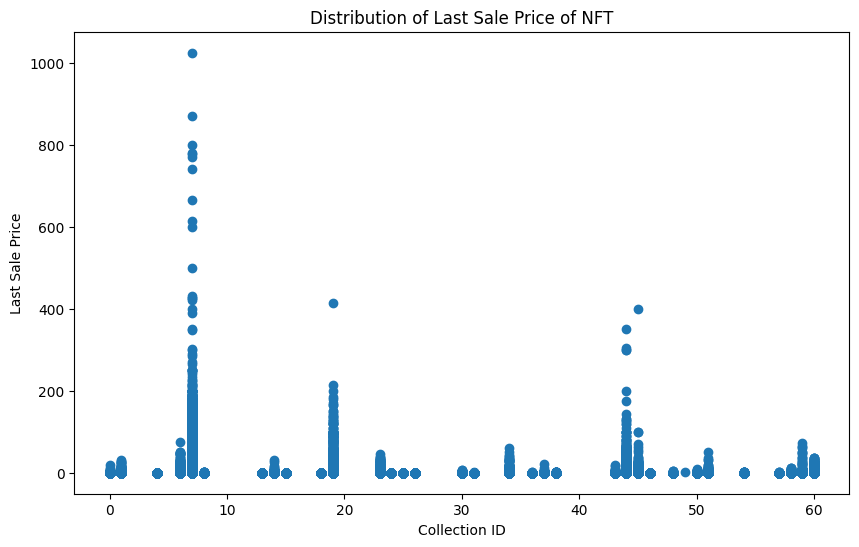

In [40]:
# Scatter Plot of last sale price with collection id
plt.figure(figsize=(10,6))
plt.scatter(X_train.collection_id, y_train)
plt.xlabel('Collection ID')
plt.ylabel('Last Sale Price')
plt.title('Distribution of Last Sale Price of NFT')
plt.show()

### Rarity Score

In [41]:
X_train['rarity_score'].describe()

count    247928.000000
mean       1437.730036
std        4308.291873
min           1.000000
25%         106.463540
50%         170.656064
75%         289.265261
max       90354.072248
Name: rarity_score, dtype: float64

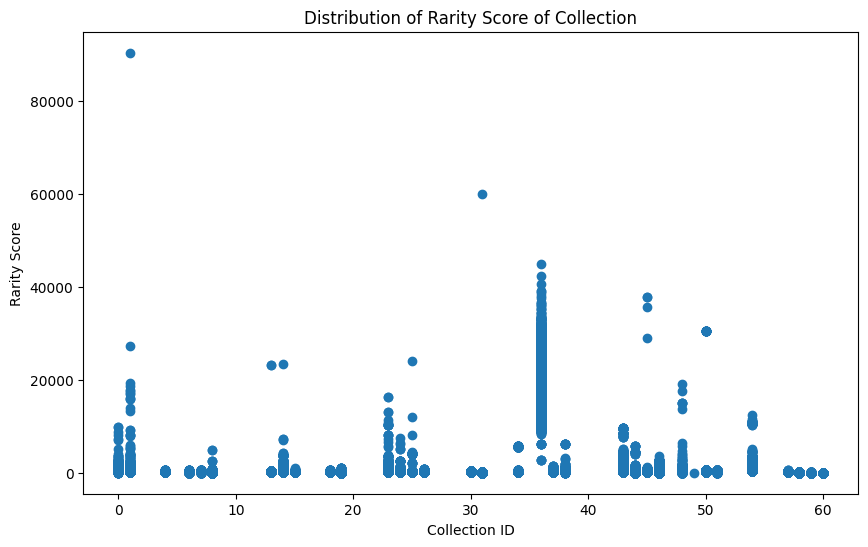

In [42]:
# Scatter Plot of rarity score with collection id
plt.figure(figsize=(10,6))
plt.scatter(X_train.collection_id, X_train['rarity_score'])
plt.xlabel('Collection ID')
plt.ylabel('Rarity Score')
plt.title('Distribution of Rarity Score of Collection')
plt.show()

### Social Media

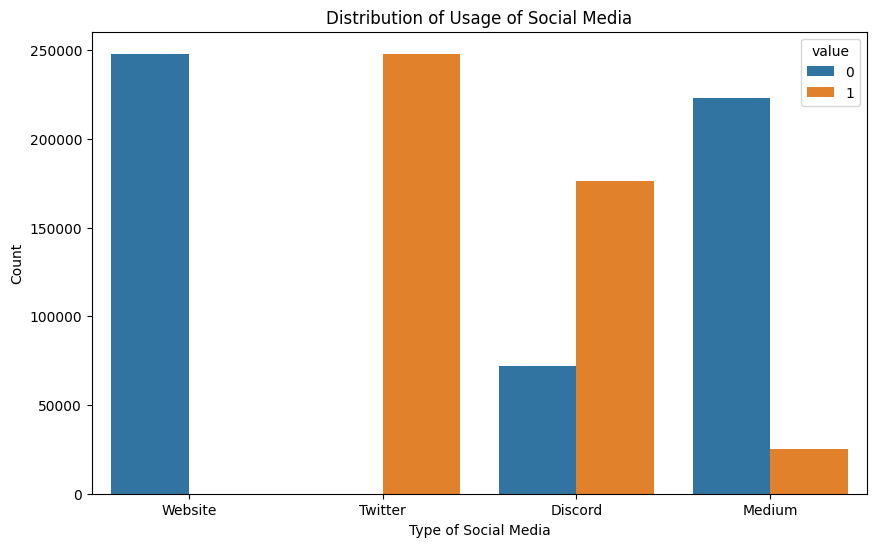

In [43]:
# Bar Plot of Distribution of Usage of Social Media
d = pd.DataFrame({'Website': X_train.has_website,
                  'Twitter': X_train.has_own_twitter,
                  'Discord': X_train.has_discord,
                  'Medium': X_train.has_medium})

usgdist = pd.melt(d)
plt.figure(figsize=(10,6))
p = sns.countplot(data = usgdist, x = 'variable', hue = 'value')
p.set(xlabel = 'Type of Social Media',
      ylabel = 'Count',
      title = 'Distribution of Usage of Social Media')
plt.show()


### Twitter Info

In [44]:
X_train['n_tweets_in_range'].describe()

count    247939.000000
mean         17.198206
std          27.144826
min           1.000000
25%           3.000000
50%          11.000000
75%          19.000000
max         668.000000
Name: n_tweets_in_range, dtype: float64

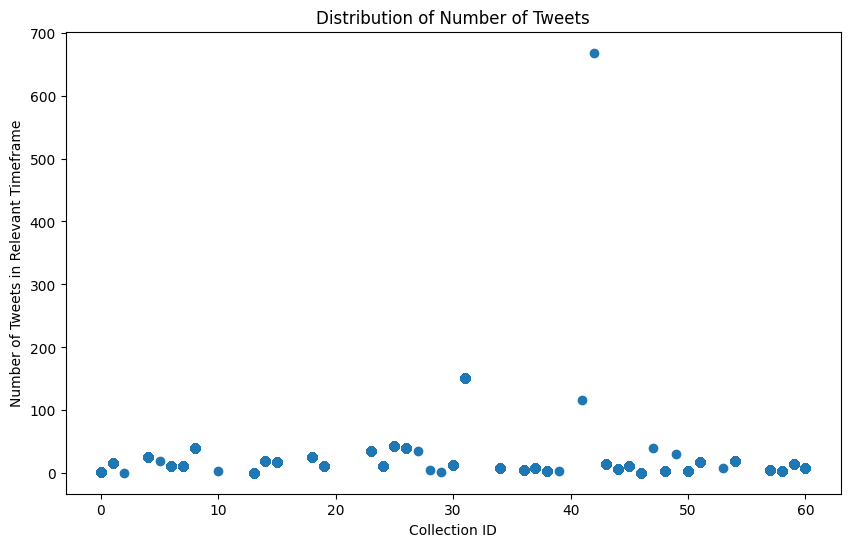

In [45]:
# Scatter Plot of collection id with number of tweets in range
plt.figure(figsize=(10,6))
plt.scatter(X_train.collection_id, X_train['n_tweets_in_range'])
plt.xlabel('Collection ID')
plt.ylabel('Number of Tweets in Relevant Timeframe')
plt.title('Distribution of Number of Tweets')
plt.show()

## Average Likes, Replies and Retweets

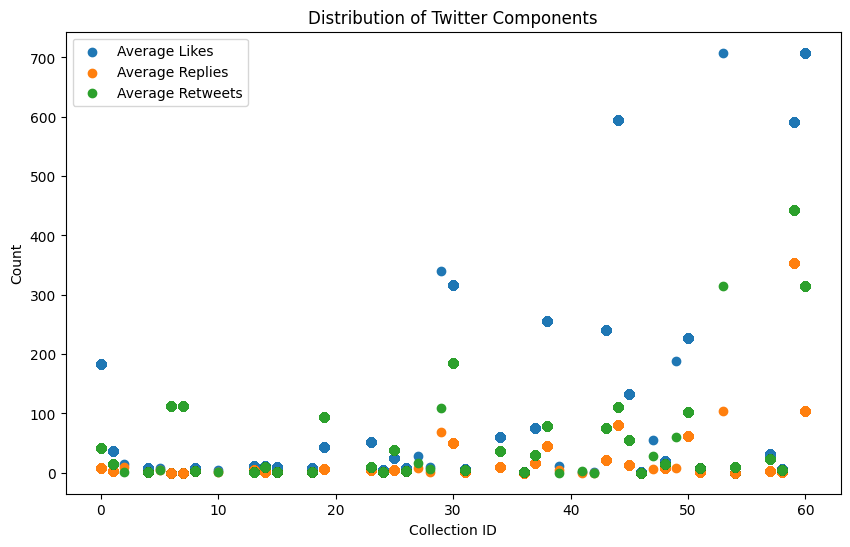

In [46]:
# Pot of average likes, average replies and average retweets
plt.figure(figsize=(10,6))
plt.scatter(X_train.collection_id, X_train.avg_likes, label = "Average Likes")
plt.scatter(X_train.collection_id, X_train.avg_replies, label = "Average Replies")
plt.scatter(X_train.collection_id, X_train.avg_retweets, label = "Average Retweets")
plt.title("Distribution of Twitter Components")
plt.xlabel("Collection ID")
plt.ylabel("Count")
plt.legend()
plt.show()

### Last Sale Price vs. Number of Tweets

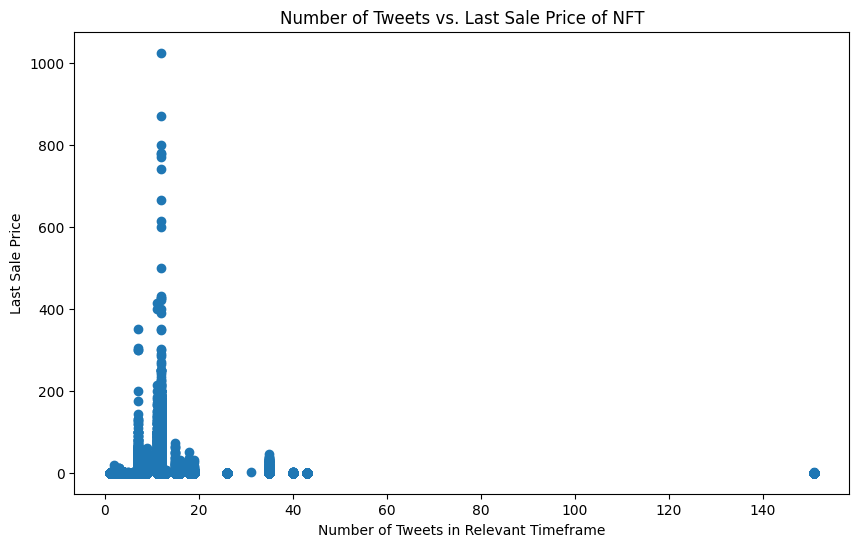

In [47]:
plt.figure(figsize=(10,6))
plt.scatter(X_train.n_tweets_in_range, y_train)
plt.xlabel("Number of Tweets in Relevant Timeframe")
plt.ylabel("Last Sale Price")
plt.title("Number of Tweets vs. Last Sale Price of NFT")
plt.show()

### Rarity Score vs. Number of Traits

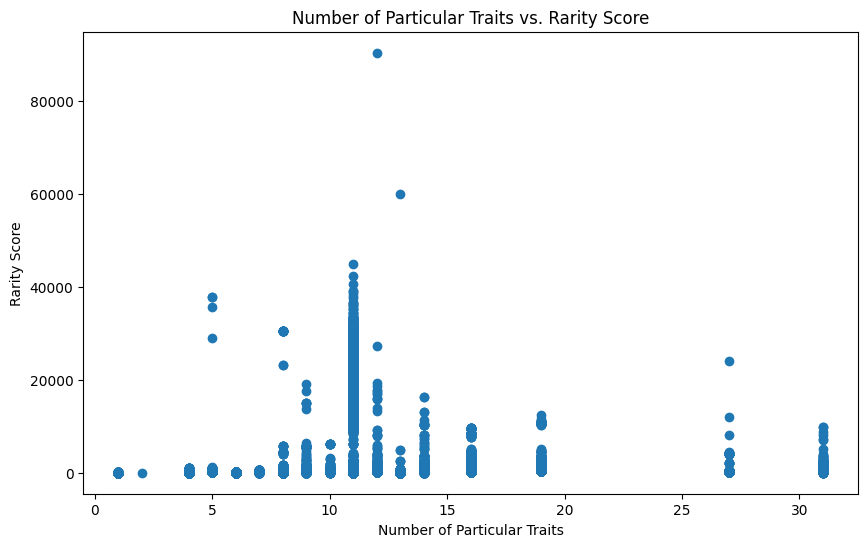

In [48]:
plt.figure(figsize=(10,6))
plt.scatter(X_train.n_of_traits, X_train.rarity_score)
plt.xlabel("Number of Particular Traits")
plt.ylabel("Rarity Score")
plt.title("Number of Particular Traits vs. Rarity Score")
plt.show()

### Last Sale Price vs. Number of Traits

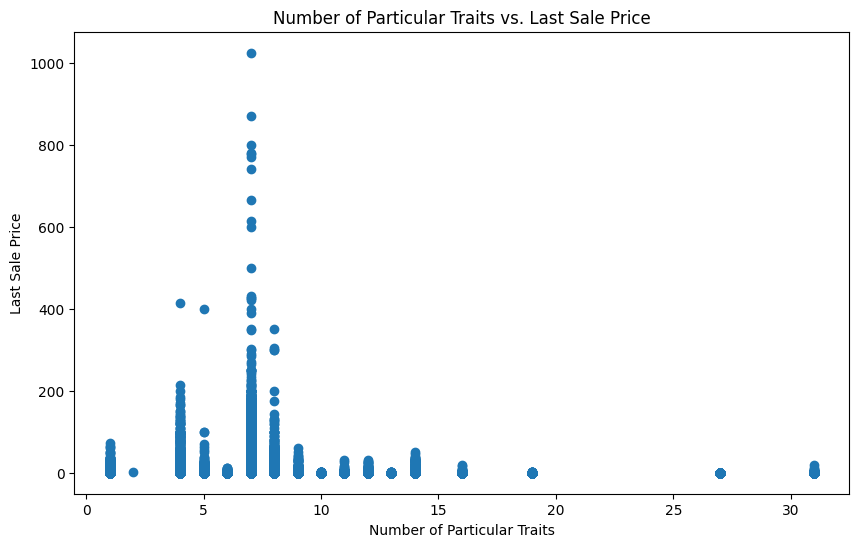

In [49]:
plt.figure(figsize=(10,6))
plt.scatter(X_train.n_of_traits, y_train)
plt.xlabel("Number of Particular Traits")
plt.ylabel("Last Sale Price")
plt.title("Number of Particular Traits vs. Last Sale Price")
plt.show()

### Average Retweets vs. Last Sale Price

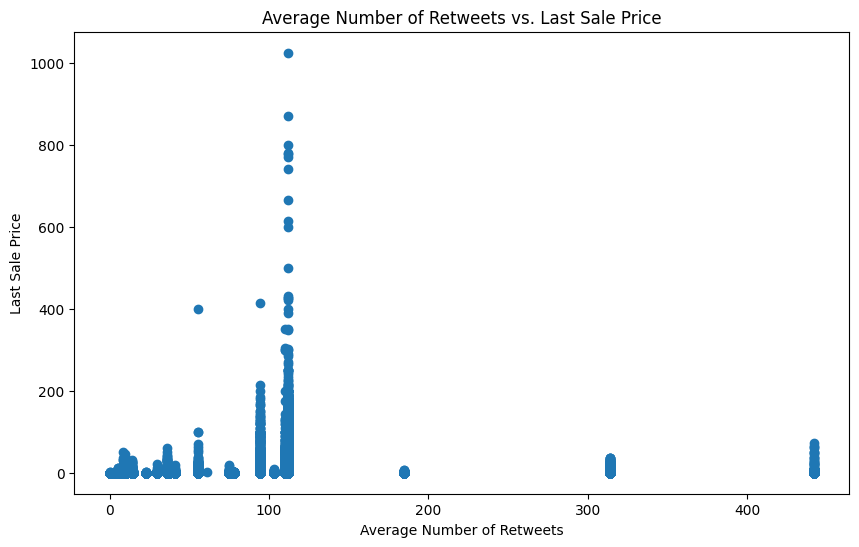

In [50]:
plt.figure(figsize=(10,6))
plt.scatter(X_train.avg_retweets, y_train)
plt.xlabel("Average Number of Retweets")
plt.ylabel("Last Sale Price")
plt.title("Average Number of Retweets vs. Last Sale Price")
plt.show()

### Auto EDA

In [51]:
# Concatenating the X_train and y_train component for the sweetviz automatic eda
xtrain = pd.concat([X_train, y_train],axis=1)

In [54]:
# performing auto eda using sweetviz, "last_sale_price" is the target variable
import sweetviz
autoeda_report = sweetviz.analyze([xtrain, "last_sale_price"])

                                             |      | [  0%]   00:00 -> (? left)

In [55]:
autoeda_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Missing Value Imputation

In [56]:
train_mod = train.copy(deep=True)
test_mod = test.copy(deep=True)

In [57]:
# Imputing all the rows of openrarity_score, openrarity_rank, openrarity_max_rank as 0 wherever openrarity is not enabled in train_mod dataframe
train_mod.loc[train_mod['openrarity_enabled'] == 0, 'openrarity_score'] = 0
train_mod.loc[train_mod['openrarity_enabled'] == 0, 'openrarity_rank'] = 0
train_mod.loc[train_mod['openrarity_enabled'] == 0, 'openrarity_max_rank'] = 0

In [58]:
# Imputing all the rows of openrarity_score, openrarity_rank, openrarity_max_rank as 0 wherever openrarity is not enabled in test_mod dataframe
test_mod.loc[test_mod['openrarity_enabled'] == 0, 'openrarity_score'] = 0
test_mod.loc[test_mod['openrarity_enabled'] == 0, 'openrarity_rank'] = 0
test_mod.loc[test_mod['openrarity_enabled'] == 0, 'openrarity_max_rank'] = 0

### Random Forest Imputation (MissForest)

In [59]:
train_mod[['seller_fees', 'global_index', 'nft_id', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'last_sale_date', 'last_sale_price']].isnull().sum()

seller_fees            32693
global_index              14
nft_id                    14
rarity_score              14
openrarity_score           5
openrarity_rank            5
openrarity_max_rank        5
last_sale_date            14
last_sale_price           14
dtype: int64

In [77]:
!pip uninstall scikit-learn -y
!pip install scikit-learn


  Using cached scikit_learn-1.4.0-1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.0-1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)


In [81]:
import missforest
forest_imputer = missforest.MissForest()
train_imputed_data = forest_imputer.fit_transform(train_mod[['seller_fees', 'global_index', 'nft_id', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank', 'last_sale_price']])

InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

In [82]:
test_mod[['seller_fees', 'global_index', 'nft_id', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank']].isnull().sum()

seller_fees             2
global_index           34
nft_id                 34
rarity_score           34
openrarity_score        8
openrarity_rank         8
openrarity_max_rank     8
dtype: int64

In [83]:
forest_imputer1 = missforest.MissForest()
test_imputed_data = forest_imputer1.fit_transform(test_mod[['seller_fees', 'global_index', 'nft_id', 'rarity_score', 'openrarity_score', 'openrarity_rank', 'openrarity_max_rank']])

InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

In [ ]:
# Adding imputed data to the original train dataframe
train_mod['imputed_seller_fees'] = train_imputed_data[:,0]
train_mod['imputed_global_index'] = train_imputed_data[:,1]
train_mod['imputed_nft_id'] = train_imputed_data[:,2]
train_mod['imputed_rarity_score'] = train_imputed_data[:,3]
train_mod['imputed_openrarity_score'] = train_imputed_data[:,4]
train_mod['imputed_openrarity_rank'] = train_imputed_data[:,5]
train_mod['imputed_openrarity_max_rank'] = train_imputed_data[:,6]
train_mod['imputed_last_sale_price'] = train_imputed_data[:,7]

In [ ]:
# Adding imputed data to the original test dataframe
test_mod['imputed_seller_fees'] = test_imputed_data[:,0]
test_mod['imputed_global_index'] = test_imputed_data[:,1]
test_mod['imputed_nft_id'] = test_imputed_data[:,2]
test_mod['imputed_rarity_score'] = test_imputed_data[:,3]
test_mod['imputed_openrarity_score'] = test_imputed_data[:,4]
test_mod['imputed_openrarity_rank'] = test_imputed_data[:,5]
test_mod['imputed_openrarity_max_rank'] = test_imputed_data[:,6]

In [ ]:
# Saving the imputed datasets to disk
train_mod.to_csv('imputed_train.csv', index=False)
test_mod.to_csv('imputed_test.csv', index=False)

In [ ]:
# Loading the train and test csv files from the disk generated from the earlier steps
train = pd.read_csv('/content/imputed_train.csv')
test = pd.read_csv('/content/imputed_test.csv')

In [ ]:
train_mod = train.copy()
test_mod = test.copy()

In [ ]:
# Imputing the nan values in the last sale date column for train dataframe
train_mod['last_sale_date'].fillna(method='ffill', inplace=True)
# Impute the nan values in the last sale date column for test dataframe
test_mod['last_sale_date'].fillna(method='bfill', inplace=True)

## Feature Engineering

In [ ]:
# Converting last sale date column from string to datetime type in train
train_mod['last_sale_date'] = pd.to_datetime(train_mod.last_sale_date)

In [ ]:
# Segregating last sale date based on the year and month values in separate columns in train
train_mod['last_sale_year'] = train_mod.last_sale_date.dt.year
train_mod['last_sale_month'] = train_mod.last_sale_date.dt.month

In [ ]:
# Converting last sale date column from string to datetime type in test
test_mod['last_sale_date'] = pd.to_datetime(test_mod.last_sale_date)

# Segregating last sale date based on the year and month values in separate columns in test
test_mod['last_sale_year'] = test_mod.last_sale_date.dt.year
test_mod['last_sale_month'] = test_mod.last_sale_date.dt.month

In [ ]:
# Converting creation date from string type to datetime type in train
train_mod['creation_date']  = pd.to_datetime(train_mod.creation_date)
# Segregating creation date by year and month values in separate columns in train
train_mod['creation_year']  = train_mod.creation_date.dt.year
train_mod['creation_month'] = train_mod.creation_date.dt.month

# Converting creation date from string type to datetime type in test
test_mod['creation_date']  = pd.to_datetime(test_mod.creation_date)
# Segregating creation date by year and month values in separate columns in test
test_mod['creation_year']  = test_mod.creation_date.dt.year
test_mod['creation_month'] = test_mod.creation_date.dt.month

In [ ]:
# Dropping the raw columns
train_mod.drop(['creation_date', 'verification_status', 'contract_type', 'last_sale_date', 
                'seller_fees', 'global_index','nft_id', 'rarity_score', 'openrarity_score',
                'openrarity_rank', 'openrarity_max_rank', 'last_sale_price'], axis=1, inplace=True)

test_mod.drop(['creation_date', 'verification_status', 'contract_type', 'last_sale_date', 
               'seller_fees', 'global_index','nft_id', 'rarity_score', 'openrarity_score',
               'openrarity_rank', 'openrarity_max_rank'], axis=1, inplace=True)

In [ ]:
# Saving the cleaned datasets
train_mod.to_csv('cleaned_train.csv', index=False)
test_mod.to_csv('cleaned_test.csv', index=False)

In [ ]:
# Loading the train and test csv files from the disk generated from the earlier steps
train_mod = pd.read_csv('/content/cleaned_train.csv')
test_mod = pd.read_csv('/content/cleaned_test.csv')

## Machine Learning Modelling

In [74]:
# Dropping all the id related columns
train_mod.drop(['collection_id', 'imputed_nft_id', 'imputed_global_index'], axis=1, inplace=True)
test_mod.drop(['collection_id', 'imputed_nft_id', 'imputed_global_index'], axis=1, inplace=True)

KeyError: "['imputed_nft_id', 'imputed_global_index'] not found in axis"

In [ ]:
# Setting the seed value
np.random.seed(42)

In [ ]:
# Train and Validation split
X = train_mod.drop(['imputed_last_sale_price'], axis=1)
y = train_mod['imputed_last_sale_price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
f'Shape of X_train: {X_train.shape}; X_val:{X_val.shape}; y_train:{y_train.shape}; y_val:{y_val.shape} and test set:{test_mod.shape}'

'Shape of X_train: (247939, 29); X_val:(61985, 29); y_train:(247939,); y_val:(61985,) and test set:(181248, 29)'

### Random Forest Regressor

In [72]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_val)
print(f'R2 Score: {r2_score(rfr_pred, y_val)}')
print(f'Mean Squared Error: {mean_squared_error(rfr_pred, y_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(rfr_pred, y_val)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(rfr_pred, y_val)}')

# Score of Random Forest Regressor
RMSE = mean_squared_error(rfr_pred, y_val, squared=False)
print(f'Root Mean Squared Error: {RMSE}')
print()
RFR_Score = np.exp(-RMSE/10)
print('Score of Random Forest Regressor is: ', RFR_Score)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_131192/3581990377.py", line 2, in <module>
    rfr.fit(X_train, y_train)
  File "/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
  File "/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
  File "/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
  File "/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1192, in check_X_y
  File "/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/sklearn/utils/validation.py", line 951, in check_array
  File "/home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packag

**Evaluation metric for the score will be based on RMSE. 
In particular, the formula shall be: exp( -RMSE / 10 ) where 10 is used as a normalization factor. 
The maximum score thus will be 1.0 and the minimum score will be 0.0**

### AdaBoost Regressor

In [73]:
ada = AdaBoostRegressor()
ada.fit(X_train, y_train)
ada_pred = ada.predict(X_val)
print(f'R2 Score: {r2_score(rfr_pred, y_val)}')
print(f'Mean Squared Error: {mean_squared_error(rfr_pred, y_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(rfr_pred, y_val)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(rfr_pred, y_val)}')

RMSE = mean_squared_error(ada_pred, y_val, squared=False)
print(f'Root Mean Squared Error: {mean_squared_error(ada_pred, y_val, squared=False)}')
print()
ADA_Score = np.exp(-RMSE/10)
print('Score of Adaboost Regressor is: ', ADA_Score)

ValueError: Input contains NaN

### LightGBM Regressor

In [ ]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_val)
print(f'R2 Score: {r2_score(lgbm_pred, y_val)}')
print(f'Mean Squared Error: {mean_squared_error(lgbm_pred, y_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(lgbm_pred, y_val)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(lgbm_pred, y_val)}')

RMSE = mean_squared_error(lgbm_pred, y_val, squared=False)
print(f'Root Mean Squared Error: {mean_squared_error(lgbm_pred, y_val, squared=False)}')
LGBM_Score = np.exp(-RMSE/10)
print()
print('Score of LightGBM Regressor is: ', LGBM_Score)

R2 Score: 0.5180158767881566
Mean Squared Error: 52.420335970282885
Mean Absolute Error: 1.1296731895857233
Mean Absolute Percentage Error: 1.3119561769742192
Root Mean Squared Error: 7.240188945758452

Score of LightGBM Regressor is:  0.48479997559089616


### CatBoost Regressor

In [ ]:
cat = catboost.CatBoostRegressor()
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_val)
print(f'R2 Score: {r2_score(cat_pred, y_val)}')
print(f'Mean Squared Error: {mean_squared_error(cat_pred, y_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(cat_pred, y_val)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(cat_pred, y_val)}')

RMSE = mean_squared_error(cat_pred, y_val, squared=False)
print(f'Root Mean Squared Error: {RMSE}')
CAT_Score = np.exp(-RMSE/10)
print()
print('Score of CatBoost Regressor is: ', CAT_Score)

Learning rate set to 0.097833
0:	learn: 12.0928375	total: 120ms	remaining: 1m 59s
1:	learn: 11.4351995	total: 203ms	remaining: 1m 41s
2:	learn: 10.8668977	total: 284ms	remaining: 1m 34s
3:	learn: 10.3758379	total: 360ms	remaining: 1m 29s
4:	learn: 9.9550779	total: 425ms	remaining: 1m 24s
5:	learn: 9.5991206	total: 468ms	remaining: 1m 17s
6:	learn: 9.2938467	total: 546ms	remaining: 1m 17s
7:	learn: 9.0337516	total: 615ms	remaining: 1m 16s
8:	learn: 8.8140267	total: 700ms	remaining: 1m 17s
9:	learn: 8.6256358	total: 778ms	remaining: 1m 17s
10:	learn: 8.4683468	total: 855ms	remaining: 1m 16s
11:	learn: 8.3372892	total: 927ms	remaining: 1m 16s
12:	learn: 8.2270522	total: 994ms	remaining: 1m 15s
13:	learn: 8.1307424	total: 1.07s	remaining: 1m 15s
14:	learn: 8.0525951	total: 1.15s	remaining: 1m 15s
15:	learn: 7.9879720	total: 1.23s	remaining: 1m 15s
16:	learn: 7.9347028	total: 1.27s	remaining: 1m 13s
17:	learn: 7.8867800	total: 1.3s	remaining: 1m 11s
18:	learn: 7.8416927	total: 1.34s	remaini

### XGBoost Regressor

In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)
print(f'R2 Score: {r2_score(xgb_pred, y_val)}')
print(f'Mean Squared Error: {mean_squared_error(xgb_pred, y_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(xgb_pred, y_val)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(xgb_pred, y_val)}')

RMSE = mean_squared_error(xgb_pred, y_val, squared=False)
print(f'Root Mean Squared Error: {RMSE}')
XGB_Score = np.exp(-RMSE/10)
print()
print('Score of XGBoost Regressor is: ', XGB_Score)

R2 Score: 0.5166323196974775
Mean Squared Error: 54.40152504474968
Mean Absolute Error: 1.1311425713576804
Mean Absolute Percentage Error: 15.35459059434508
Root Mean Squared Error: 7.375738949064675

Score of XGBoost Regressor is:  0.47827284930079267


## Hyperparameter Tuning

### Bayesian Optimization

#### 1. Bayesian Optimization using bayes_opt library on LGBMRegressor

In [ ]:
def lgbm_objective(num_leaves, learning_rate, max_depth, min_child_samples, subsample):
    model = lightgbm.LGBMRegressor(
        num_leaves=int(num_leaves),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        n_jobs=-1
    )
    score = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

pbounds = {
    'num_leaves': (10, 1000),
    'learning_rate': (0.001, 0.5),
    'max_depth': (1, 15),
    'min_child_samples': (1, 40),
    'subsample': (0.01, 1.0)
}

optimizer = BayesianOptimization(
    f=lgbm_objective,
    pbounds=pbounds,
    random_state=42,
    allow_duplicate_points=True
)

optimizer.maximize(
    init_points=10,
    n_iter=10
)

best_params = optimizer.max['params']
print("Best score: %f" % (optimizer.max['target']))
print("Best parameters: ", best_params)

best_model = lightgbm.LGBMRegressor(
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    min_child_samples=int(best_params['min_child_samples']),
    subsample=best_params['subsample'],
    n_jobs=-1
)

best_model.fit(X_train, y_train)

|   iter    |  target   | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------
| 1         | 63.1      | 0.1879    | 14.31     | 29.55     | 602.7     | 0.1645    |
| 2         | 124.0     | 0.07884   | 1.813     | 34.78     | 605.1     | 0.711     |
| 3         | 69.89     | 0.01127   | 14.58     | 33.47     | 220.2     | 0.19      |
| 4         | 58.78     | 0.09252   | 5.259     | 21.47     | 437.6     | 0.2983    |
| 5         | 68.62     | 0.3063    | 2.953     | 12.39     | 372.7     | 0.4615    |
| 6         | 59.5      | 0.3928    | 3.795     | 21.06     | 596.5     | 0.05599   |
| 7         | 60.09     | 0.3042    | 3.387     | 3.537     | 949.4     | 0.966     |
| 8         | 62.98     | 0.4044    | 5.265     | 4.809     | 687.4     | 0.4458    |
| 9         | 66.26     | 0.0619    | 7.932     | 2.341     | 910.2     | 0.2662    |
| 10        | 59.75     | 0.3316    | 5.364     | 21.2

LGBMRegressor(learning_rate=0.03636189468550917, max_depth=1,
              min_child_samples=34, num_leaves=604,
              subsample=0.6719801831853792)

In [ ]:
best_lgbm_pred = best_model.predict(X_val)
print(f'R2 Score: {r2_score(best_lgbm_pred, y_val)}')
print(f'Mean Squared Error: {mean_squared_error(best_lgbm_pred, y_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(best_lgbm_pred, y_val)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(best_lgbm_pred, y_val)}')

RMSE = mean_squared_error(best_lgbm_pred, y_val, squared=False)
print(f'Root Mean Squared Error: {RMSE}')
LGBM_Score = np.exp(-RMSE/10)
print()
print('Score of LightGBM Regressor is: ', LGBM_Score)

R2 Score: -5.948795877997159
Mean Squared Error: 119.46584938025548
Mean Absolute Error: 3.279953389662574
Mean Absolute Percentage Error: 1.1570234048375387
Root Mean Squared Error: 10.930043429934553

Score of LightGBM Regressor is:  0.33520789987911803


#### 2. Bayesian Optimization using bayes_opt library on XGBRegressor

In [ ]:
def xgb_objective(learning_rate, max_depth, subsample, colsample_bytree):
    model = xgboost.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        n_jobs=-1
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

pbounds = {
    'learning_rate': (0.01, 0.5),
    'max_depth': (1, 10),
    'subsample': (0.1, 1.0),
    'colsample_bytree': (0.1, 1.0)
}

optimizer = BayesianOptimization(
    f=xgb_objective,
    pbounds=pbounds,
    random_state=42
)

optimizer.maximize(
    init_points=10,
    n_iter=3
)

best_params = optimizer.max['params']
print("Best score: %f" % (optimizer.max['target']))
print("Best parameters: ", best_params)

best_model = xgboost.XGBRegressor(
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    n_jobs=-1
)

best_model.fit(X_train, y_train)

|   iter    |  target   | colsam... | learni... | max_depth | subsample |
-------------------------------------------------------------------------
| 1         | -67.11    | 0.4371    | 0.4759    | 7.588     | 0.6388    |
| 2         | -123.8    | 0.2404    | 0.08644   | 1.523     | 0.8796    |
| 3         | -110.4    | 0.641     | 0.357     | 1.185     | 0.9729    |
| 4         | -81.16    | 0.8492    | 0.114     | 2.636     | 0.2651    |
| 5         | -61.47    | 0.3738    | 0.2671    | 4.888     | 0.3621    |
| 6         | -66.67    | 0.6507    | 0.07835   | 3.629     | 0.4297    |
| 7         | -69.69    | 0.5105    | 0.3947    | 2.797     | 0.5628    |
| 8         | -60.27    | 0.6332    | 0.03276   | 6.468     | 0.2535    |
| 9         | -65.55    | 0.1585    | 0.475     | 9.691     | 0.8276    |
| 10        | -60.84    | 0.3742    | 0.05786   | 7.158     | 0.4961    |
| 11        | -74.18    | 0.1       | 0.5       | 6.008     | 1.0       |
| 12        | -61.36    | 0.9964    | 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6331731119758383, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03276070223279889,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
# On validation set
best_xgb_pred = best_model.predict(X_val)
print(f'R2 Score: {r2_score(best_xgb_pred, y_val)}')
print(f'Mean Squared Error: {mean_squared_error(best_xgb_pred, y_val)}')
print(f'Mean Absolute Error: {mean_absolute_error(best_xgb_pred, y_val)}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(best_xgb_pred, y_val)}')

RMSE = mean_squared_error(best_xgb_pred, y_val, squared=False)
print(f'Root Mean Squared Error: {RMSE}')
XGB_Score = np.exp(-RMSE/10)
print()
print('Score of XGBoost Regressor is: ', XGB_Score)

R2 Score: 0.41078652845859864
Mean Squared Error: 52.38432107594895
Mean Absolute Error: 1.199236664678376
Mean Absolute Percentage Error: 0.7898712523511333
Root Mean Squared Error: 7.237701366867035

Score of XGBoost Regressor is:  0.4849205884105533


In [ ]:
# On train set
mean_squared_error(best_model.predict(X_train), y_train, squared=False)

7.329821464633528

In [ ]:
# Predictions on test set
test_pred = best_model.predict(test_mod)

## Feature Importance

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, X_train.columns), reverse=True), columns=['Value', 'Features'])
feature_imp.head()

,Value,Features
0,0.198587,max_retweets
1,0.182153,last_sale_year
2,0.118118,imputed_seller_fees
3,0.110303,creation_month
4,0.093145,avg_retweets


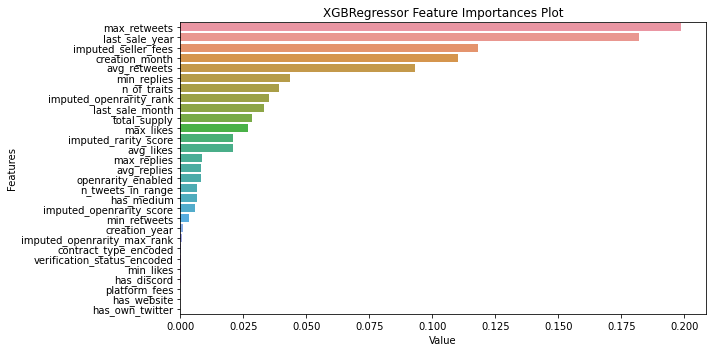

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='Value', y='Features', data=feature_imp)
plt.title('XGBRegressor Feature Importances Plot')
plt.tight_layout()
plt.show()

## Model Explainability

In [ ]:
explainer = RegressionExplainer(best_model, X_val, y_val)

Changing class type to XGBRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [ ]:
db = ExplainerDashboard(explainer, shap_interactive=False)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating importances...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [ ]:
db.model_summary

True

In [ ]:
db.save_html('dashboard.html')

# Improved Version of NFT Price Prediction

In [85]:
# Import all 4 files (datasets)
train = pd.read_csv("nfts_train.csv")
collections = pd.read_csv("collections.csv").drop("Unnamed: 0", axis=1)
test = pd.read_csv("nfts_predict.csv")
sub = pd.read_csv("submission_format.csv")
twitter = pd.read_csv("collections_twitter_stats.csv").drop("Unnamed: 0", axis=1)

# Keep target last
target = train.last_sale_price
train = train.drop("last_sale_price", axis=1)

# Merging train and test dataframes to smoothen the data pre-processing part and avoid redundancy. Then split back after data pre-processing is finished.
data = pd.concat([train, test]).reset_index()

# Combine both the twitter and collections data to 'data' DataFrame. These two datasets have additional features which would be helpful for the model to learn better and generalize.
data = data.merge(collections, how='left', on='collection_id')
data = data.merge(twitter, how='left', on='collection_id')

# Extract creation date month and year; last sale date year and month from 'creation_date' and 'last_sale_date' columns respectively.
data["creation_date"] = pd.to_datetime(data.creation_date)
data['creation_date_year'] = data.creation_date.dt.year
data['creation_date_month'] = data.creation_date.dt.month

data["last_sale_date"] = pd.to_datetime(data.last_sale_date)
data['last_sale_date_year'] = data.last_sale_date.dt.year
data['last_sale_date_month'] = data.last_sale_date.dt.month

# Calculate difference in days  from last_sale_date and creation_date column.
data['diff_days'] = (data["last_sale_date"] - data['creation_date']).dt.days
data = data.drop(columns = ["last_sale_date", "creation_date"], axis=1)  # Dropping creation_date and last_sale_date columns

# Create a feature 'has_all' that has all the communication mediums: {website, twitter, discord, medium and openrarity enabled}. A score of '1' would be given to each medium.
data["has_all"] = data.select_dtypes(include=["bool_"]).T.sum()
data_bool = data.select_dtypes(include=["bool_"]).columns.tolist()
for i in data_bool:
    data[i] = data[i].map({True:1, False:0})

# Encode the unique categories in the verification_status and contract_type columns
data.verification_status.unique()
v_stat = []
for i in data.verification_status:
    if i ==  'approved':
        v_stat.append(1)
    elif i ==  'verified':
        v_stat.append(3)
    else:
        v_stat.append(0)
data.verification_status = v_stat

data["contract_type"] = data["contract_type"].map({"default":0, "own":1})
data = data.drop(columns = ["index"])  # Dropping index column

# Statistical feature engineering on columns: {rarity_score, total_supply, n_of_traits, seller_fees}
data_nft_stats = data.groupby("nft_id").agg(
             nft_rarity_score_min = ('rarity_score', 'min'),
             nft_rarity_score_max = ('rarity_score', 'max'),
             nft_rarity_score_mean = ('rarity_score', 'mean'), 
             nft_rarity_score_sum = ('rarity_score', 'sum'),
             nft_rarity_score_std = ('rarity_score', 'std'),
             nft_rarity_score_median = ('rarity_score', 'median'), 

             nft_total_supply_min = ('total_supply', 'min'),
             nft_total_supply_max = ('total_supply', 'max'),
             nft_total_supply_mean = ('total_supply', 'mean'), 
             nft_total_supply_sum = ('total_supply', 'sum'),
             nft_total_supply_std = ('total_supply', 'std'),
             nft_total_supply_median = ('total_supply', 'median'), 

             nft_n_of_traits_min = ('n_of_traits', 'min'),
             nft_n_of_traits_max = ('n_of_traits', 'max'),
             nft_n_of_traits_mean = ('n_of_traits', 'mean'), 
             nft_n_of_traits_sum = ('n_of_traits', 'sum'),
             nft_n_of_traits_std = ('n_of_traits', 'std'),
             nft_n_of_traits_median = ('n_of_traits', 'median'), 

             nft_seller_fees_min = ('seller_fees', 'min'),
             nft_seller_fees_max = ('seller_fees', 'max'),
             nft_seller_fees_mean = ('seller_fees', 'mean'), 
             nft_seller_fees_sum = ('seller_fees', 'sum'),
             nft_seller_fees_std = ('seller_fees', 'std'),
             nft_seller_fees_median = ('seller_fees', 'median'), 

             nft_platform_fees_min = ('platform_fees', 'min'),
             nft_platform_fees_max = ('platform_fees', 'max'),
             nft_platform_fees_mean = ('platform_fees', 'mean'), 
             nft_platform_fees_sum = ('platform_fees', 'sum'),
             nft_platform_fees_std = ('platform_fees', 'std'),
             nft_platform_fees_median = ('platform_fees', 'median'), 
).reset_index()
data = data.merge(data_nft_stats, how='left', on='nft_id') # Merge the new statistical features created in the above step to 'data' DataFrame


# Split 'data' back into train and test sets
df_train = data[:train.shape[0]]
df_test = data[train.shape[0]:]
print(f'Shape of df_train: {df_train.shape} and Shape of df_test: {df_test.shape}')

# Saving the final train and test dataframes in csv formats
df_train.to_csv('final_train.csv', index=False)
df_test.to_csv('final_test.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'submission_format.csv'

In [3]:
# Read the final train and test csv files as well as the target csv
df_train = pd.read_csv('final_train.csv')
df_test  = pd.read_csv('final_test.csv')
target   = pd.read_csv('target.csv')

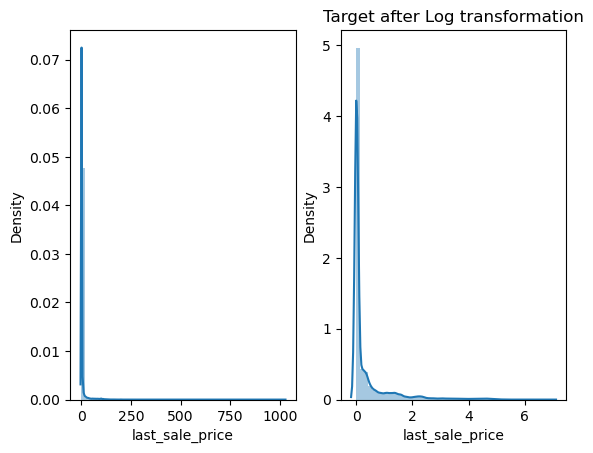

In [3]:
# Creating X and y variables
X = df_train
y = target.last_sale_price

# Checking the data distribution of the target column
y_transformed = pd.Series(np.log1p(y))  # Natural logarithm of (1+y)
fig, ax = plt.subplots(1, 2)
sns.distplot(y, ax=ax[0])  
plt.title("Target after Log transformation")
sns.distplot(y_transformed, ax=ax[1])
plt.show()

### CatBoost Regressor (Improved)

In [30]:
fold_pred=[]   # list to keep track of the scores per fold.
oof_pred = []  # list to keep track of out of fold predictions.
cat_model = None

# Set Hyperparameters.
params = {
 'learning_rate': 0.163251453473545997,
 'max_depth': 14,
 'subsample': 0.6530887571489526, 'thread_count': -1}

# Create a Kfold with 16 splits. Set the random state to 2023.
fold= KFold(n_splits=16, shuffle=True, random_state = 2023)
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = np.log1p(y.iloc[train_index]), y.iloc[test_index]

    cat_model = catboost.CatBoostRegressor(**params)
    cat_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], early_stopping_rounds=200, verbose = False)

    preds= cat_model.predict(X_val)
    print("Error: ",mean_squared_error(y_val, np.expm1(preds), squared=False))  # Reverse transformation
    oof_pred.append(mean_squared_error(y_val, np.expm1(preds), squared=False))
    p2 = cat_model.predict(df_test[X.columns])
    fold_pred.append(np.expm1(p2))

print()
print('CatBoost Regressor - Mean RMSE or average out of fold predictions: ',np.mean(oof_pred))
print('CatBoost Regressor - Mean fold predictions (on Test set): ',np.mean(fold_pred))

Error:  9.152924230138769
Error:  8.823829717648787
Error:  8.455304889178247
Error:  7.236973533489786
Error:  9.661864287158853
Error:  9.338672446849683
Error:  11.241018458177962
Error:  8.769641792662625
Error:  11.335870270529707
Error:  7.152566996209874
Error:  6.773640851896774
Error:  9.48762569048258
Error:  8.036133523387983
Error:  9.970045718988215
Error:  7.883304818282118
Error:  7.132005734530389

CatBoost Regressor - Mean RMSE or average out of fold predictions:  8.778213934975772
CatBoost Regressor - Mean fold predictions (on Test set):  0.37810196359775594


In [ ]:
# Save CatBoost Regressor Model
cat_model.save_model('catboostreg')

In [5]:
# Load Catboost regressor model
loaded_cat_model = catboost.CatBoostRegressor()
loaded_cat_model.load_model('catboostreg')
loaded_cat_model.get_params()

{'loss_function': 'RMSE',
 'subsample': 0.6530887571,
 'depth': 14,
 'od_wait': 200,
 'learning_rate': 0.1632514535,
 'verbose': 0,
 'od_type': 'Iter'}

### XGBRegressor (Improved)

In [18]:
fold_pred_xgb =[]   # list to keep track of the scores per fold.
oof_pred_xgb = []  # list to keep track of out of fold predictions.
xgb_model = None  

# Set Hyperparameters.
params_xgb = {'colsample_bytree': 0.6331731119758383, 'learning_rate': 0.03276070223279889, 'max_depth': 7, 'subsample': 0.2534717113185624, 'n_jobs':-1}

# Create a Kfold with 16 splits. Set the random state to 2023.
fold= KFold(n_splits=16, shuffle=True, random_state = 2023)
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = np.log1p(y.iloc[train_index]), y.iloc[test_index] 

    xgb_model = xgboost.XGBRegressor(**params_xgb)
    xgb_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], verbose = False)

    preds= xgb_model.predict(X_val)
    print("Error: ",mean_squared_error(y_val, np.expm1(preds), squared=False))  # Reverse transformation
    oof_pred_xgb.append(mean_squared_error(y_val, np.expm1(preds), squared=False))
    p2 = xgb_model.predict(df_test[X.columns])
    fold_pred_xgb.append(np.expm1(p2))

print()
print('XGBRegressor - Mean RMSE or average out of fold predictions: ',np.mean(oof_pred_xgb))
print('XGBRegressor - Mean fold predictions (on Test Set): ',np.mean(fold_pred_xgb))

Error:  9.527487323587241
Error:  9.474150363268526
Error:  8.822849699732052
Error:  7.6224815597410425
Error:  10.146420125876059
Error:  9.973335604518821
Error:  11.567007845652263
Error:  9.45369777714076
Error:  11.610877983871047
Error:  7.807033817753469
Error:  7.141450451555527
Error:  9.951475476290508
Error:  8.6349053785121
Error:  10.556307059517678
Error:  8.140349931663781
Error:  7.412807535910146

XGBRegressor - Mean RMSE or average out of fold predictions:  9.24016487091194
XGBRegressor - Mean fold predictions (on Test Set):  0.4719953


In [ ]:
# Save XGBoost Regressor Model
xgb_model.save_model('xgboostreg')

In [75]:
# Load xgboost regressor model
loaded_xgb_model = xgboost.XGBRegressor()
loaded_xgb_model.load_model('xgboostreg')

XGBoostError: [05:04:24] /workspace/dmlc-core/src/io/local_filesys.cc:209: Check failed: allow_null:  LocalFileSystem::Open "xgboostreg": No such file or directory
Stack trace:
  [bt] (0) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x1ba24e) [0x7909b27ba24e]
  [bt] (1) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0xcc9637) [0x7909b32c9637]
  [bt] (2) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0xcb54ce) [0x7909b32b54ce]
  [bt] (3) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(XGBoosterLoadModel+0x18e) [0x7909b276eace]
  [bt] (4) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/lib-dynload/../../libffi.so.8(+0xa052) [0x790a1b992052]
  [bt] (5) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/lib-dynload/../../libffi.so.8(+0x8925) [0x790a1b990925]
  [bt] (6) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/lib-dynload/../../libffi.so.8(ffi_call+0xde) [0x790a1b99106e]
  [bt] (7) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x92e4) [0x790a1b9a22e4]
  [bt] (8) /home/labeeb/miniconda3/envs/nft-cnn/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x8836) [0x790a1b9a1836]



## LightGBM Regressor (Improved)

In [31]:
fold_pred_lgb =[]   # list to keep track of the scores per fold.
oof_pred_lgb = []  # list to keep track of out of fold predictions.
lgb_model = None  

# Set Hyperparameters.
params_lgb = {
    'learning_rate': 0.03636189468550917, 
    'max_depth':1, 
    'min_child_samples':34, 
    'num_leaves': 604, 
    'subsample': 0.6719801831853792}

# Create a Kfold with 16 splits. Set the random state to 2023.
fold= KFold(n_splits=16, shuffle=True, random_state = 2023)
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = np.log1p(y.iloc[train_index]), y.iloc[test_index] 

    lgb_model = lightgbm.LGBMRegressor(**params_lgb)
    lgb_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], verbose = False)

    preds= lgb_model.predict(X_val)
    print("Error: ",mean_squared_error(y_val, np.expm1(preds), squared=False))  # Reverse transformation
    oof_pred_lgb.append(mean_squared_error(y_val, np.expm1(preds), squared=False))
    p2 = lgb_model.predict(df_test[X.columns])
    fold_pred_lgb.append(np.expm1(p2))

print()
print('LightGBM - Mean RMSE or average out of fold predictions: ',np.mean(oof_pred_lgb))
print('LightGBM - Mean fold predictions (on Test set): ',np.mean(fold_pred_lgb))

Error:  12.600664021233767
Error:  12.807908355854071
Error:  11.91958230895631
Error:  11.19036964264094
Error:  13.34898048379173
Error:  13.334769487893618
Error:  14.292377615316248
Error:  12.425168588808496
Error:  14.378004964888726
Error:  11.31506904530466
Error:  10.623421990099533
Error:  12.652025787199621
Error:  12.273885880945645
Error:  13.578375132525295
Error:  11.6462527050376
Error:  11.26770914222752

LightGBM - Mean RMSE or average out of fold predictions:  12.478410322045235
LightGBM - Mean fold predictions (on Test set):  0.3949422173829646


### Bagging Regressor with Base Estimator as LightGBM Regressor

In [32]:
fold_pred_lgb_bagging =[]   # list to keep track of the scores per fold.
oof_pred_lgb_bagging = []  # list to keep track of out of fold predictions.
#lgb_model = None  

# Create a Kfold with 16 splits. Set the random state to 2023.
fold= KFold(n_splits=16, shuffle=True, random_state = 2023)
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = np.log1p(y.iloc[train_index]), y.iloc[test_index] 

    bagging_lgbm = BaggingRegressor(estimator=lgb_model)
    bagging_lgbm.fit(X_train,y_train)

    preds= bagging_lgbm.predict(X_val)
    print("Error: ",mean_squared_error(y_val, np.expm1(preds), squared=False))  # Reverse transformation
    oof_pred_lgb_bagging.append(mean_squared_error(y_val, np.expm1(preds), squared=False))
    p2 = bagging_lgbm.predict(df_test[X.columns])
    fold_pred_lgb_bagging.append(np.expm1(p2))

print()
print('Bagging Regressor with base -> LightGBM - Mean RMSE or average out of fold predictions: ',np.mean(oof_pred_lgb_bagging))
print('Bagging Regressor with base -> LightGBM - Mean fold predictions (on Test set): ',np.mean(fold_pred_lgb_bagging))

Error:  12.602206208615586
Error:  12.810895579318066
Error:  11.91937371892095
Error:  11.192061553713325
Error:  13.350370824884104
Error:  13.331924748569337
Error:  14.293363350342613
Error:  12.42482253816146
Error:  14.380445276581883
Error:  11.315025975221893
Error:  10.624413181626878
Error:  12.650542954013565
Error:  12.27278863595609
Error:  13.578568084299187
Error:  11.646612628079442
Error:  11.266257275449055

Bagging Regressor with base -> LightGBM - Mean RMSE or average out of fold predictions:  12.478729533359589
Bagging Regressor with base -> LightGBM - Mean fold predictions (on Test set):  0.39352974880928887


### Hyperparameter Tuning - Light GBM

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
def lgbm_objective(n_estimators, num_leaves, learning_rate, max_depth, min_child_samples, colsample_bytree, subsample):
    model = lightgbm.LGBMRegressor(
        n_estimators=int(n_estimators),
        num_leaves=int(num_leaves),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        min_child_samples=int(min_child_samples),
        colsample_bytree=colsample_bytree,
        subsample=subsample,
        n_jobs=-1
    )
    score = -cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean()
    return score

pbounds = {
    'n_estimators': (100, 700),
    'num_leaves': (10, 1000),
    'learning_rate': (0.001, 0.5),
    'max_depth': (1, 15),
    'min_child_samples': (1, 40),
    'colsample_bytree':(0.1, 1.0),
    'subsample': (0.01, 1.0)
}

optimizer = BayesianOptimization(
    f=lgbm_objective,
    pbounds=pbounds,
    random_state=42,
    allow_duplicate_points=True
)

optimizer.maximize(
    init_points=5,
    n_iter=20
)

best_params = optimizer.max['params']
print("Best score: %f" % (optimizer.max['target']))
print("Best parameters: ", best_params)

best_model = lightgbm.LGBMRegressor(
    n_estimators=int(best_params['n_estimators']),
    num_leaves=int(best_params['num_leaves']),
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    min_child_samples=int(best_params['min_child_samples']),
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    n_jobs=-1
)

best_model.fit(X_train, y_train)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 69.6      | 0.4371    | 0.4754    | 11.25     | 24.35     | 193.6     | 164.4     | 0.0675    |
| 2         | 70.47     | 0.8796    | 0.301     | 10.91     | 1.803     | 681.9     | 834.1     | 0.2202    |
| 3         | 56.23     | 0.2636    | 0.09252   | 5.259     | 21.47     | 359.2     | 298.3     | 0.6157    |
| 4         | 58.27     | 0.2255    | 0.1468    | 6.129     | 18.79     | 571.1     | 207.7     | 0.5191    |
| 5         | 56.89     | 0.6332    | 0.02418   | 9.506     | 7.65      | 139.0     | 949.4     | 0.966     |
| 6         | 63.22     | 0.8954    | 0.2139    | 4.828     | 1.311     | 682.3     | 826.1     | 0.6194    |
| 7         | 76.72     | 0.5832    | 0.4724    | 9.331     | 1.756     | 678.2     | 835.4     | 0.8847    |
| 8       

LGBMRegressor(colsample_bytree=0.5831990788602335,
              learning_rate=0.47243417232945284, max_depth=9,
              min_child_samples=1, n_estimators=678, num_leaves=835,
              subsample=0.8846994022058565)

In [35]:
fold_pred_lgb =[]   # list to keep track of the scores per fold.
oof_pred_lgb = []  # list to keep track of out of fold predictions.
lgb_model = None  

# Create a Kfold with 16 splits. Set the random state to 2023.
fold= KFold(n_splits=16, shuffle=True, random_state = 2023)
i=1
for train_index, test_index in fold.split(X,y):     
  
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = np.log1p(y.iloc[train_index]), y.iloc[test_index] 

    lgb_model = best_model
    lgb_model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)], verbose = False)

    preds= lgb_model.predict(X_val)
    print("Error: ",mean_squared_error(y_val, np.expm1(preds), squared=False))  # Reverse transformation
    oof_pred_lgb.append(mean_squared_error(y_val, np.expm1(preds), squared=False))
    p2 = lgb_model.predict(df_test[X.columns])
    fold_pred_lgb.append(np.expm1(p2))

print()
print('Tuned LightGBM - Mean RMSE or average out of fold predictions: ',np.mean(oof_pred_lgb))
print('Tuned LightGBM - Mean fold predictions (on Test set): ',np.mean(fold_pred_lgb))

Error:  10.622567151448798
Error:  10.112053315861306
Error:  9.667608798674307
Error:  9.450216022975027
Error:  10.326726486474973
Error:  10.166985574667136
Error:  13.085292268568628
Error:  10.049665693567151
Error:  12.557676850142338
Error:  8.462984930147602
Error:  8.662127815631361
Error:  10.735067069547673
Error:  9.911950453186705
Error:  11.591621796953172
Error:  9.300637419034967
Error:  8.290590323273353

Tuned LightGBM - Mean RMSE or average out of fold predictions:  10.187110748134657
Tuned LightGBM - Mean fold predictions (on Test set):  0.7455538629058912


### Feature Importances of Improved CatBoost Regressor Model

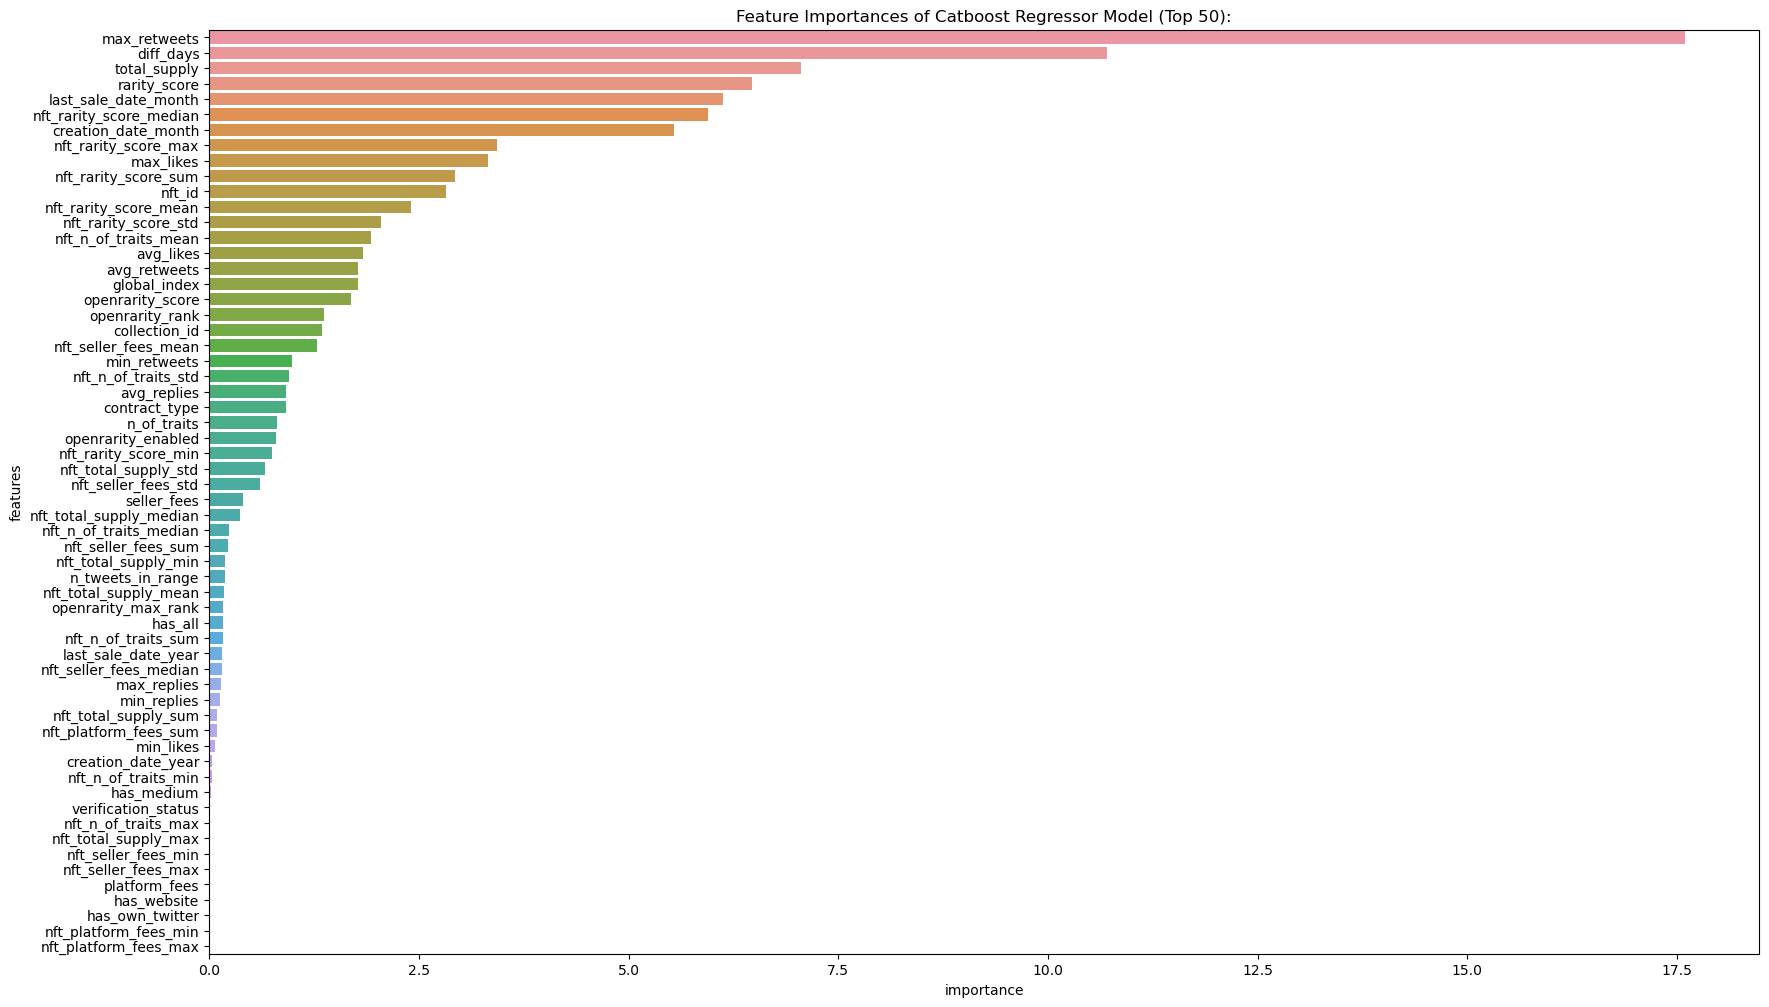

In [ ]:
feature_importance_df = pd.DataFrame(cat_model.feature_importances_, columns=['importance'])
feature_importance_df['features'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="features", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Feature Importances of Catboost Regressor Model (Top 50):')
plt.show()

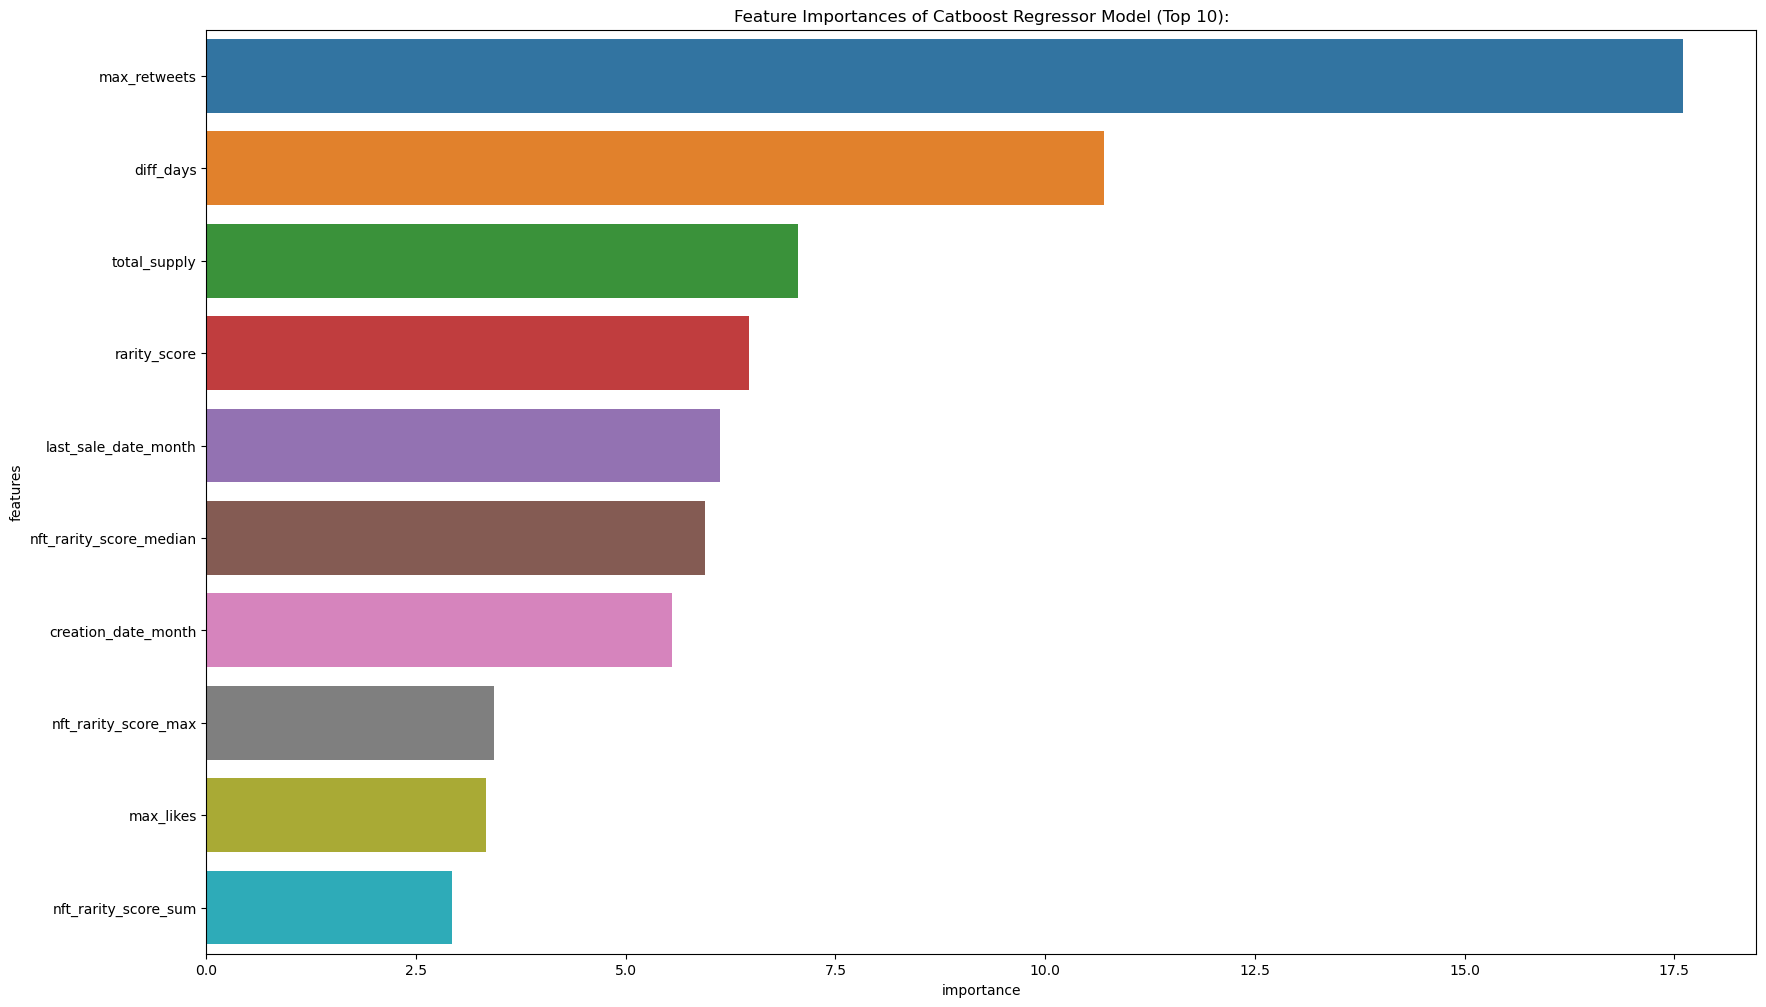

In [ ]:
plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="features", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(10))
plt.title('Feature Importances of Catboost Regressor Model (Top 10):')
plt.show()

### Improved Model Explainability

In [ ]:
explainer = RegressionExplainer(cat_model, X, y)

Generating self.shap_explainer = shap.TreeExplainer(model)


In [ ]:
db = ExplainerDashboard(explainer, shap_interactive=False)

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [ ]:
db.save_html('improved_model_dashboard.html')